In [144]:
import import_ipynb
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.UtilityFunctions import vectorize, results_conf_matrix, retrieve_processed_reviews_df, model_metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from statsmodels.miscmodels.ordinal_model import OrderedModel

In [145]:
df = retrieve_processed_reviews_df()

../processed_data
Concatenating ../processed_data\processed_data-1.csv
Concatenating ../processed_data\processed_data-2.csv
Concatenating ../processed_data\processed_data-3.csv
Concatenating ../processed_data\processed_data-4.csv
Concatenating ../processed_data\processed_data-5.csv


In [33]:
df

,Id,Score,Summary,Text,Sentiment,Clean_text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,i have bought several of the vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1,product arrived labeled as jumbo salted peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,0,this is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...,-1,if you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...,1,great taffy at a great price there was a wide...
...,...,...,...,...,...,...
568449,568450,5,Will not do without,Great for sesame chicken..this is a good if no...,1,great for sesame chickenthis is a good if not ...
568450,568451,2,disappointed,I'm disappointed with the flavor. The chocolat...,-1,im disappointed with the flavor the chocolate ...
568451,568452,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1,these stars are small so you can give 1015 of ...
568452,568453,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,1,these are the best treats for training and rew...


In [62]:
'''from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=[-1, 0, 1], ordered=True)
df['Sentiment'] = df['Sentiment'].astype(cat_type)'''

In [65]:
df

,Id,Score,Summary,Text,Sentiment,Clean_text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,i have bought several of the vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1,product arrived labeled as jumbo salted peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,0,this is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...,-1,if you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...,1,great taffy at a great price there was a wide...
...,...,...,...,...,...,...
568422,568450,5,Will not do without,Great for sesame chicken..this is a good if no...,1,great for sesame chickenthis is a good if not ...
568423,568451,2,disappointed,I'm disappointed with the flavor. The chocolat...,-1,im disappointed with the flavor the chocolate ...
568424,568452,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1,these stars are small so you can give 1015 of ...
568425,568453,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,1,these are the best treats for training and rew...


In [146]:
X = df['Clean_text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
X_train_counts, X_train_tfidf = vectorize(X_train)

In [13]:
from sklearn.base import clone
import numpy as np
# Source:
# 1. https://stackoverflow.com/questions/66486947/how-to-use-ordinal-classifier
# 2. https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c


class OrdinalClassifier():

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0] - 1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: v.predict_proba(X) for k, v in self.clfs.items()}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:, 1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                predicted.append(clfs_predict[i - 1][:, 1] - clfs_predict[i][:, 1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i - 1][:, 1])
        return np.vstack(predicted).T

    def predict(self, X):
        return self.unique_class[np.argmax(self.predict_proba(X), axis=1)]

In [111]:
log = LogisticRegression()
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("Ordinal", OrdinalClassifier(log))])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

C:\Users\ddeha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ddeha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('Ordinal',
                 <__main__.OrdinalClassifier object at 0x0000017CEEC778E0>)])

In [129]:
predictedOrdReg = clf_randomForest_pipe.predict(X_test)
np.mean(predictedOrdReg == y_test)

0.936420797365849


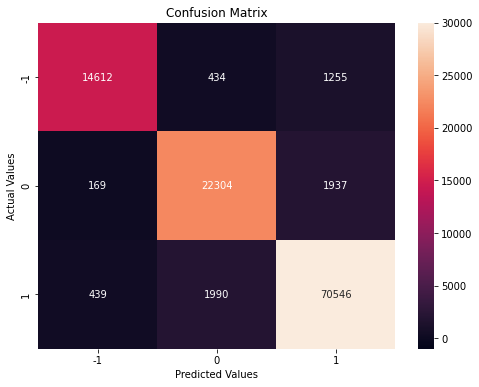

In [209]:
svm_conf = results_conf_matrix(y_test, predictedOrdReg)

In [208]:
model_metrics(y_test, predictedOrdReg)


Accuracy: 0.945

Micro Precision: 0.945
Micro Recall: 0.945
Micro F1-score: 0.945

Macro Precision: 0.940
Macro Recall: 0.926
Macro F1-score: 0.932

Weighted Precision: 0.945
Weighted Recall: 0.945
Weighted F1-score: 0.945

Classification Report

              precision    recall  f1-score   support

          -1       0.96      0.90      0.93     16301
           0       0.90      0.91      0.91     24410
           1       0.96      0.97      0.96     72975

    accuracy                           0.95    113686
   macro avg       0.94      0.93      0.93    113686
weighted avg       0.95      0.95      0.95    113686



In [210]:
np.unique(y_test, return_counts = True)

(array([-1,  0,  1], dtype=int64), array([16301, 24410, 72975], dtype=int64))

In [211]:
np.unique(predictedOrdReg, return_counts = True)

(array([-1,  0,  1]), array([15220, 24728, 73738], dtype=int64))